In [43]:
import os
import pandas as pd
import javalang
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore')

In [ ]:
"""
## 3. Carga y Exploración del Dataset

"""

def load_dataset(base_dir):
    """
    Carga el dataset de archivos Java desde la estructura de carpetas especificada.
    
    Args:
        base_dir (str): Ruta base del dataset
        
    Returns:
        DataFrame: Contiene información de todos los archivos Java encontrados
    """
    data = []
    
    for case_name in os.listdir(base_dir):
        case_path = os.path.join(base_dir, case_name)
        if not os.path.isdir(case_path):
            continue

        # Original
        orig_path = os.path.join(case_path, "original")
        for f in os.listdir(orig_path):
            if f.endswith(".java"):
                data.append({
                    "file_path": os.path.join(orig_path, f),
                    "label": "original",
                    "case_id": case_name,
                    "plagiarism_level": "original"
                })

        # Non-plagiarized
        non_plag_path = os.path.join(case_path, "non-plagiarized")
        for folder in os.listdir(non_plag_path):
            subfolder = os.path.join(non_plag_path, folder)
            for f in os.listdir(subfolder):
                if f.endswith(".java"):
                    data.append({
                        "file_path": os.path.join(subfolder, f),
                        "label": "non-plagiarized",
                        "case_id": case_name,
                        "plagiarism_level": "non-plagiarized"
                    })

        # Plagiarized
        plag_path = os.path.join(case_path, "plagiarized")
        for level in os.listdir(plag_path):  # L1 to L6
            level_path = os.path.join(plag_path, level)
            for folder in os.listdir(level_path):
                file_folder = os.path.join(level_path, folder)
                for f in os.listdir(file_folder):
                    if f.endswith(".java"):
                        data.append({
                            "file_path": os.path.join(file_folder, f),
                            "label": "plagiarized",
                            "case_id": case_name,
                            "plagiarism_level": level
                        })

    return pd.DataFrame(data)

dataset_path = "C:/Users/adria/OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey/AppAvanzadas/IR-Plag-Dataset/IR-Plag-Dataset"
df = load_dataset(dataset_path)

print(f"Total de archivos cargados: {len(df)}")
print("\nDistribución de clases:")
print(df['label'].value_counts())


Total de archivos cargados: 467

Distribución de clases:
label
plagiarized        355
non-plagiarized    105
original             7
Name: count, dtype: int64


In [ ]:
"""
## 4. Preprocesamiento y Extracción de Características
"""

def read_java_code(file_path):
    """Lee el contenido de un archivo Java"""
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        return f.read()

def get_ast_tokens(code):
    """Extrae los tokens del AST de un código Java"""
    try:
        tree = javalang.parse.parse(code)
        tokens = []
        for path, node in tree:
            tokens.append(type(node).__name__)
        return tokens
    except Exception as e:
        print(f"Error parsing code: {e}")
        return []

def ast_token_string(file_path):
    """Convierte un archivo Java en una cadena de tokens AST"""
    code = read_java_code(file_path)
    tokens = get_ast_tokens(code)
    return ' '.join(tokens) if tokens else ''

print("Extrayendo tokens AST...")
df['ast_tokens'] = df['file_path'].apply(ast_token_string)

initial_count = len(df)
df = df[df['ast_tokens'] != '']
print(f"Se eliminaron {initial_count - len(df)} archivos que no se pudieron parsear")

Extrayendo tokens AST...
Se eliminaron 0 archivos que no se pudieron parsear


In [ ]:
"""
## 5. Creación de Pares para Entrenamiento
"""

def create_pairs(df, samples_per_case=1000):
    """
    Crea pares de archivos para entrenamiento, con una mezcla de plagio y no plagio.
    
    Args:
        df (DataFrame): Dataset completo
        samples_per_case (int): Número de pares a generar por caso
        
    Returns:
        DataFrame: Pares de archivos con etiqueta de similitud
    """
    pairs = []
    cases = df['case_id'].unique()
    
    for case in cases:
        case_data = df[df['case_id'] == case]
        original = case_data[case_data['label'] == 'original'].iloc[0]
        plagiarized = case_data[case_data['label'] == 'plagiarized']
        non_plagiarized = case_data[case_data['label'] == 'non-plagiarized']
        
        # Crear pares positivos (plagio)
        for _, row in plagiarized.iterrows():
            pairs.append({
                'file1': original['file_path'],
                'file2': row['file_path'],
                'label': 1,  # 1 = plagio
                'plagiarism_level': row['plagiarism_level']
            })
        
        # Crear pares negativos (no plagio)
        for _, row in non_plagiarized.sample(min(len(non_plagiarized), samples_per_case)).iterrows():
            pairs.append({
                'file1': original['file_path'],
                'file2': row['file_path'],
                'label': 0,  # 0 = no plagio
                'plagiarism_level': 'non-plagiarized'
            })
    
    return pd.DataFrame(pairs)

# Crear pares de entrenamiento
pairs_df = create_pairs(df)
print(f"Total de pares creados: {len(pairs_df)}")
print("\nDistribución de clases en pares:")
print(pairs_df['label'].value_counts())


Total de pares creados: 460

Distribución de clases en pares:
label
1    355
0    105
Name: count, dtype: int64


In [ ]:

"""
## 6. Vectorización y División del Dataset
"""

# Vectorizar los tokens AST
vectorizer = TfidfVectorizer()
all_ast_texts = list(df['ast_tokens'])
vectorizer.fit(all_ast_texts)

# Función para calcular similitud entre pares
def calculate_similarity(pair):
    try:
        # Obtener AST tokens para cada archivo
        ast1 = ast_token_string(pair['file1'])
        ast2 = ast_token_string(pair['file2'])
        
        # Vectorizar
        vec1 = vectorizer.transform([ast1])
        vec2 = vectorizer.transform([ast2])
        
        # Calcular similitud coseno
        return cosine_similarity(vec1, vec2)[0][0]
    except:
        return 0

# Calcular características para los pares
print("Calculando similitudes...")
pairs_df['similarity'] = pairs_df.apply(calculate_similarity, axis=1)

# Dividir en train (80%) y test (20%)
train_df, test_df = train_test_split(pairs_df, test_size=0.2, random_state=42, stratify=pairs_df['label'])

print(f"\nTamaño del conjunto de entrenamiento: {len(train_df)}")
print(f"Tamaño del conjunto de prueba: {len(test_df)}")


Calculando similitudes...

Tamaño del conjunto de entrenamiento: 368
Tamaño del conjunto de prueba: 92


In [ ]:

"""
## 7. Entrenamiento del Modelo
"""

# Preparar características y etiquetas
X_train = train_df[['similarity']]
y_train = train_df['label']
X_test = test_df[['similarity']]
y_test = test_df['label']

# Entrenar modelo Random Forest
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

Evaluación en conjunto de entrenamiento:
Accuracy: 0.9755
Precision: 0.9825
Recall: 0.9859
F1 Score: 0.9842


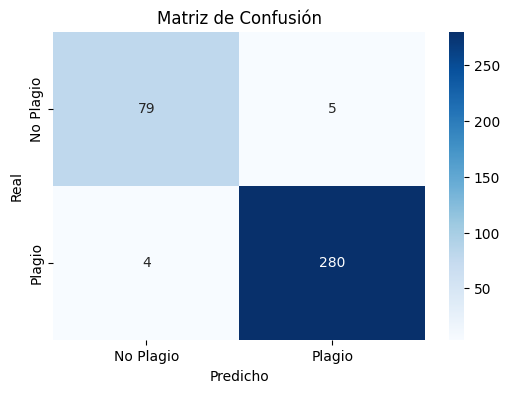


Evaluación en conjunto de prueba:
Accuracy: 0.7283
Precision: 0.8194
Recall: 0.8310
F1 Score: 0.8252


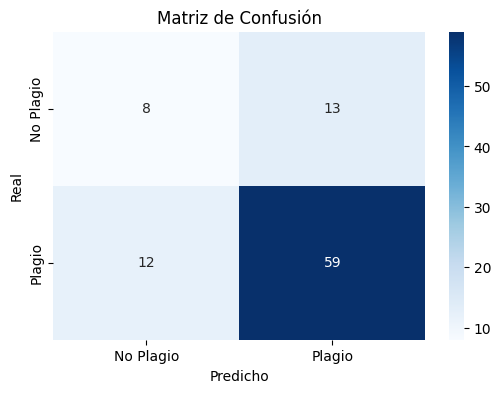

In [ ]:

from sklearn.metrics import confusion_matrix

"""
## 8. Evaluación del Modelo
"""

def evaluate_model(model, X, y):
    """Evalúa el modelo y muestra métricas"""
    y_pred = model.predict(X)
    
    print(f"Accuracy: {accuracy_score(y, y_pred):.4f}")
    print(f"Precision: {precision_score(y, y_pred):.4f}")
    print(f"Recall: {recall_score(y, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y, y_pred):.4f}")
    
    # Matriz de confusión
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Plagio', 'Plagio'], 
                yticklabels=['No Plagio', 'Plagio'])
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()

print("Evaluación en conjunto de entrenamiento:")
evaluate_model(model, X_train, y_train)

print("\nEvaluación en conjunto de prueba:")
evaluate_model(model, X_test, y_test)
